#### Importing necessary libraries

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime, timedelta

#### Defining a list of stock tickers

In [46]:
tickers = ["AAPL", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "PYPL",
           "CSCO", "IBM", "CELH", "WMT", "CVX", "AMD", "PEP", "NFLX"]


#### Setting up start and end dates for data retrieval

In [47]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 3*365)

#### Retrieving adjusted close prices for each ticker and storing in a DataFrame

In [48]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [49]:
adj_close_df.head()

,AAPL,GOOGL,AMZN,TSLA,NVDA,JPM,PYPL,CSCO,IBM,CELH,WMT,CVX,AMD,PEP,NFLX
Date,,,,,,,,,,,,,,,
2021-02-09,133.849350,103.769501,165.250000,283.153320,142.311798,128.305771,284.200012,44.340118,101.301567,20.613333,139.202454,80.270851,90.910004,128.416260,559.070007
2021-02-10,133.239197,104.323997,164.328995,268.273346,147.310486,128.379333,283.179993,43.188198,101.417725,20.290001,137.579742,81.647514,92.349998,126.668488,563.590027
2021-02-11,132.983307,104.437500,163.106506,270.553345,152.164581,128.020828,285.029999,43.499039,100.314278,21.379999,137.474747,81.206276,92.660004,124.157181,557.590027
2021-02-12,133.219528,104.751503,163.885498,272.040009,149.276062,129.840881,298.369995,43.233910,100.223015,20.580000,137.904312,81.673996,93.769997,123.145309,556.520020
2021-02-16,131.074112,105.535004,163.447495,265.406677,152.957794,132.966278,304.790009,42.520813,99.617363,20.750000,139.040207,83.347580,91.459999,123.614449,557.280029


/Users/achyut/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/achyut/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/achyut/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/achyut/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

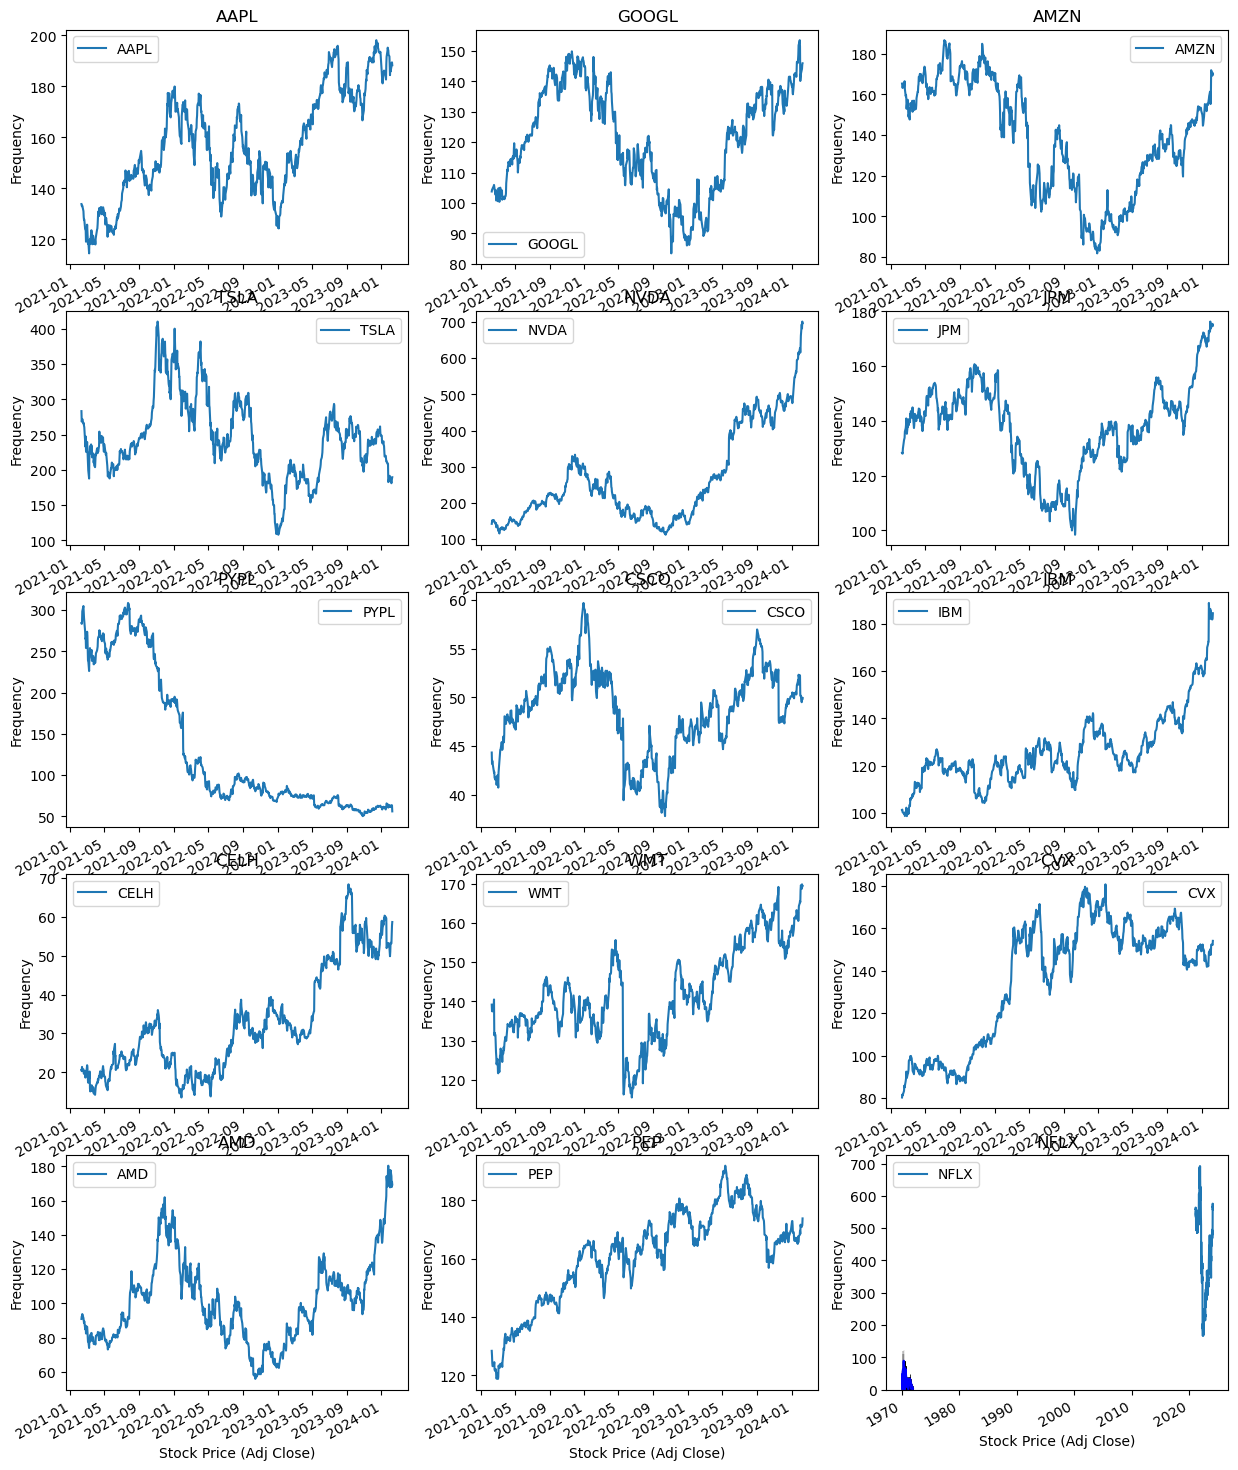

In [50]:
num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    sns.histplot(adj_close_df[ticker], kde=True, color='blue', bins=30)
    adj_close_df[ticker].plot(ax=ax, label=ticker)
    ax.set_title(ticker)
    ax.set_xlabel('Stock Price (Adj Close)')
    ax.set_ylabel('Frequency')
    ax.legend()
    
for i in range(len(tickers), num_rows * num_cols):
    axes[i].axis('off')


#### Calculating log returns

In [51]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns

,AAPL,GOOGL,AMZN,TSLA,NVDA,JPM,PYPL,CSCO,IBM,CELH,WMT,CVX,AMD,PEP,NFLX
Date,,,,,,,,,,,,,,,
2021-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-10,-0.004569,0.005329,-0.005589,-0.053982,0.034522,0.000573,-0.003596,-0.026323,0.001146,-0.015810,-0.011726,0.017005,0.015716,-0.013704,0.008052
2021-02-11,-0.001922,0.001087,-0.007467,0.008463,0.032420,-0.002796,0.006512,0.007172,-0.010940,0.052328,-0.000763,-0.005419,0.003351,-0.020025,-0.010703
2021-02-12,0.001775,0.003002,0.004765,0.005480,-0.019165,0.014117,0.045740,-0.006114,-0.000910,-0.038136,0.003120,0.005743,0.011908,-0.008183,-0.001921
2021-02-16,-0.016235,0.007452,-0.002676,-0.024686,0.024365,0.023786,0.021289,-0.016631,-0.006061,0.008227,0.008203,0.020284,-0.024943,0.003802,0.001365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,-0.005420,0.008606,0.075726,-0.005043,0.048513,0.005740,0.006429,0.000000,-0.005957,0.043089,0.007458,0.028990,0.041254,-0.004261,-0.005070
2024-02-05,0.009798,0.009089,-0.008769,-0.037135,0.046831,-0.001317,-0.014198,-0.013442,-0.012838,-0.002628,-0.005381,0.000591,-0.019495,-0.000293,-0.004580
2024-02-06,0.008595,0.002919,-0.006834,0.022068,-0.016125,0.003433,0.034654,0.009448,-0.000054,0.047528,0.006795,0.000131,-0.037127,0.002921,-0.011056


#### Counting NaN values in log returns

In [52]:
log_returns.isna().sum()

AAPL     1
GOOGL    1
AMZN     1
TSLA     1
NVDA     1
JPM      1
PYPL     1
CSCO     1
IBM      1
CELH     1
WMT      1
CVX      1
AMD      1
PEP      1
NFLX     1
dtype: int64

#### Calculating mean log returns

In [53]:
log_returns.mean()

AAPL     0.000453
GOOGL    0.000452
AMZN     0.000036
TSLA    -0.000532
NVDA     0.002106
JPM      0.000410
PYPL    -0.002151
CSCO     0.000158
IBM      0.000794
CELH     0.001388
WMT      0.000260
CVX      0.000865
AMD      0.000825
PEP      0.000402
NFLX    -0.000001
dtype: float64

#### Dropping NaN values from log returns

In [54]:
log_returns.dropna(inplace=True)

#### Calculating covariance matrix of log returns

In [55]:
cov_matrix = log_returns.cov() * 252
cov_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,AAPL,GOOGL,AMZN,TSLA,NVDA,JPM,PYPL,CSCO,IBM,CELH,WMT,CVX,AMD,PEP,NFLX
AAPL,0.074972,0.058273,0.062045,0.085831,0.091067,0.025185,0.064350,0.032761,0.017634,0.073380,0.015937,0.015514,0.082245,0.017535,0.061130
GOOGL,0.058273,0.098526,0.078574,0.075945,0.101335,0.025816,0.066351,0.032898,0.016020,0.075871,0.015077,0.016023,0.095653,0.014852,0.066974
AMZN,0.062045,0.078574,0.140678,0.099349,0.117310,0.028627,0.089866,0.032394,0.014804,0.108114,0.019053,0.015479,0.110006,0.015731,0.093058
TSLA,0.085831,0.075945,0.099349,0.343385,0.166571,0.036800,0.122420,0.035147,0.007688,0.158829,0.016336,0.014276,0.149442,0.010805,0.110822
NVDA,0.091067,0.101335,0.117310,0.166571,0.273251,0.043531,0.116857,0.046068,0.019045,0.159821,0.016907,0.021222,0.210622,0.016036,0.118912
JPM,0.025185,0.025816,0.028627,0.036800,0.043531,0.057037,0.038600,0.022350,0.022136,0.042435,0.009085,0.025788,0.038393,0.009676,0.029349
PYPL,0.064350,0.066351,0.089866,0.122420,0.116857,0.038600,0.214481,0.031451,0.014723,0.118619,0.017517,0.018743,0.102138,0.013365,0.112903
CSCO,0.032761,0.032898,0.032394,0.035147,0.046068,0.022350,0.031451,0.055805,0.020337,0.033646,0.016876,0.015844,0.045178,0.016823,0.028733
IBM,0.017634,0.016020,0.014804,0.007688,0.019045,0.022136,0.014723,0.020337,0.043914,0.022440,0.009205,0.017008,0.022435,0.012375,0.000706
CELH,0.073380,0.075871,0.108114,0.158829,0.159821,0.042435,0.118619,0.033646,0.022440,0.510874,0.021066,0.021356,0.143834,0.023899,0.095470


#### Heatmap of correlation between log returns of all assets

<Axes: >

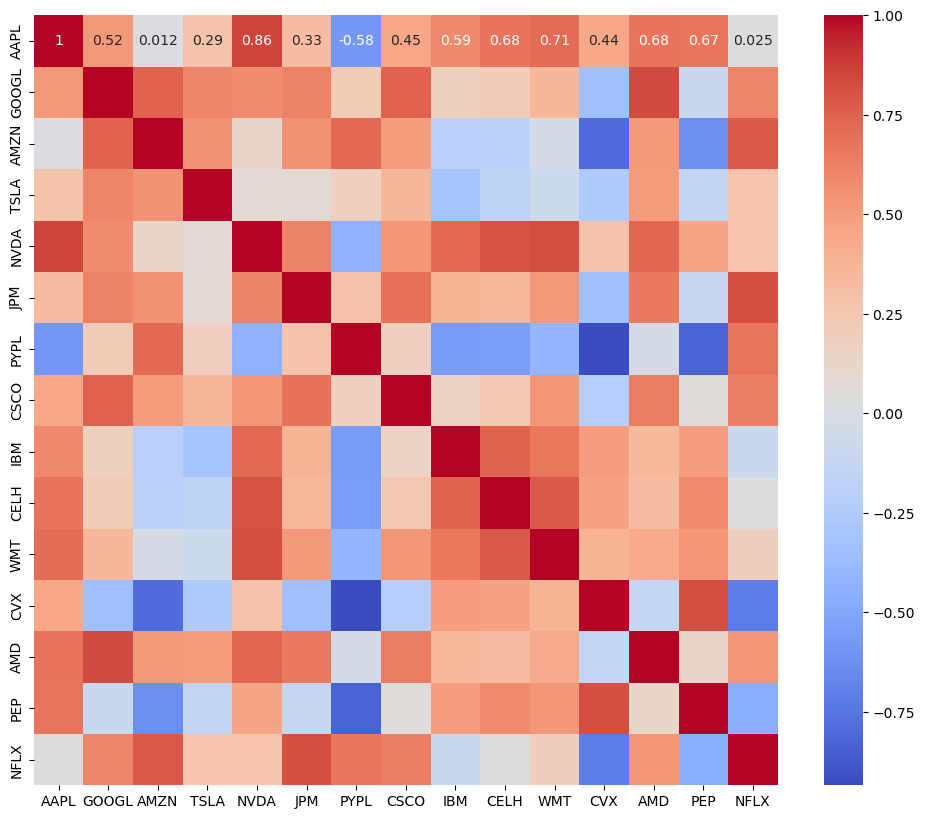

In [56]:
import matplotlib.pyplot as plt

corr_matrix = adj_close_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Defining a function to calculate standard deviation

In [57]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### Defining a function to calculate expected annualized returns

In [58]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights*252)

#### Defining a function to calculate the sharpe ratio

In [59]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

#### Retrieving risk-free rate from FRED API

In [60]:
from fredapi import Fred

fred = Fred(api_key='37d707ea29d05517c0f3f400b23644bb')
treasury_rate_10y = fred.get_series_latest_release('GS10')/100
risk_free_rate = treasury_rate_10y[-1]
risk_free_rate

/var/folders/t1/r4wwd84d6xb75g5c6kcczbsm0000gn/T/ipykernel_1208/2153171841.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = treasury_rate_10y[-1]


0.0406

#### Defining a function to calculate negative Sharpe ratio

In [61]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Defining constraints and bounds for optimization

In [62]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

#### Setting initial weights for optimization

In [63]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

#### Optimizing portfolio weights - Medium risk goal

In [64]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x


#### Printing optimal weights for each ticker

In [65]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
AAPL: 0.0000
GOOGL: 0.0000
AMZN: 0.0000
TSLA: 0.0000
NVDA: 0.2818
JPM: 0.0000
PYPL: 0.0000
CSCO: 0.0000
IBM: 0.4505
CELH: 0.0000
WMT: 0.0000
CVX: 0.2677
AMD: 0.0000
PEP: 0.0000
NFLX: 0.0000


#### Calculating expected annual return, volatility, and Sharpe ratio of the optimal portfolio

In [66]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 0.2980
Expected Volatility: 0.2189
Sharpe Ratio: 1.1758


#### Generating samples for plotting Volatility vs Returns with Sharpe Ratio

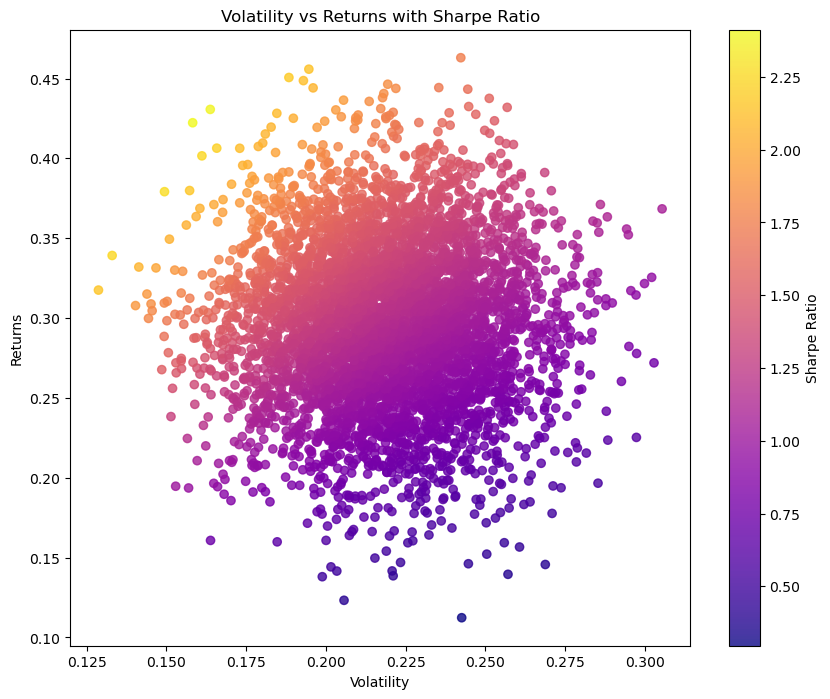

In [67]:
num_samples = 5000

volatility_samples = np.random.normal(optimal_portfolio_volatility, 0.025, num_samples)
returns_samples = np.random.normal(optimal_portfolio_return, 0.05, num_samples)
sharpe_ratio_samples = (returns_samples - risk_free_rate) / volatility_samples

plt.figure(figsize=(10,8))
plt.scatter(volatility_samples, returns_samples, c=sharpe_ratio_samples, cmap='plasma', alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Volatility vs Returns with Sharpe Ratio')
plt.show()



#### Plotting Volatility vs Returns with Sharpe Ratio

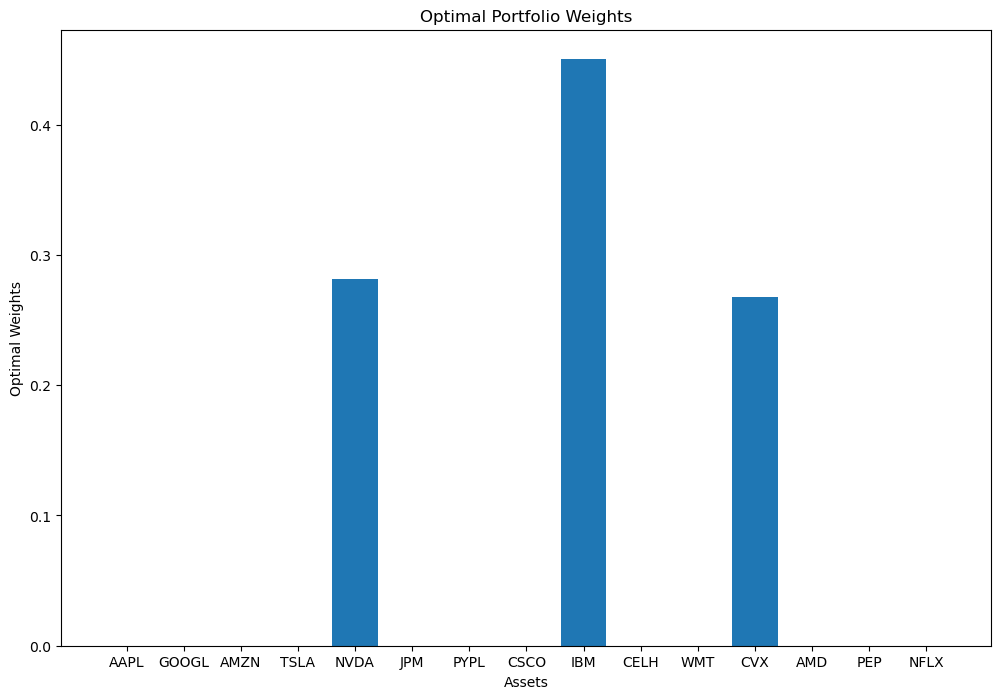

In [68]:
plt.figure(figsize=(12, 8))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

## Black-Litterman Implementation